In [ ]:
#!pip install shap
!pip install imblearn
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, auc,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,roc_auc_score, balanced_accuracy_score,classification_report , RocCurveDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from scipy.stats import randint, uniform
#import shap
import pickle

pd.set_option('display.max_columns', 500)
sns.set()

sns.set_style('darkgrid')




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Collection**

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(44)

# Define the number of records
num_records = 8800

# Define UK regions and features with adjusted probabilities
uk_regions = ["London", "East Midlands", "West Midlands", "South East England",
              "North East England"]
uk_education_levels = ["Bachelor", "Master", "PhD", "Diploma", "High School"]
uk_work_status = ["Employed", "Unemployed", "Self-employed", "Retired"]
uk_relationship_status = ["Married", "Single", "Divorced", "Widowed"]
uk_vehicle_types = ["Hatchback", "Sedan", "SUV", "Convertible", "Truck"]
uk_reachability = ["Email", "Phone", "Agent", "Online Portal"]

# Define more varied probabilities for categorical columns
uk_regions_prob = [0.3, 0.2, 0.2, 0.2, 0.1]
uk_education_levels_prob = [0.25, 0.2, 0.15, 0.25, 0.15]
uk_work_status_prob = [0.5, 0.2, 0.2, 0.1]
uk_relationship_status_prob = [0.5, 0.3, 0.15, 0.05]
uk_vehicle_types_prob = [0.4, 0.3, 0.2, 0.05, 0.05]

# Define average premiums by region (for comprehensive plans)
average_premiums = {
    "London": 1277.34,
    "East Midlands": 811.33,
    "West Midlands": 986.39,
    "South East England": 746.26,
    "North East England": 715.39
}

# Define average annual and monthly incomes by region
average_annual_income = {
    "London": 48000,
    "East Midlands": 32000,
    "West Midlands": 35000,
    "South East England": 36000,
    "North East England": 30000
}
average_monthly_income = {region: income / 12 for region,
                          income in average_annual_income.items()}

# Generate normally distributed numerical values
age_mean, age_std = 40, 12  # Mean age 40, standard deviation 12
weeks_mean, weeks_std = 30, 20 #Mean weeks since claim 30,standard deviation 20

# Generate synthetic data with adjusted probabilities and normal distributions
synthetic_uk_data = pd.DataFrame({
    "region": np.random.choice(uk_regions, num_records, p=uk_regions_prob),
    "churn": np.random.choice(["Yes", "No"], num_records, p=[0.3, 0.7]),
    "type_of_plan": np.random.choice(["Third Party Only", "Third Party, Fire and Theft", "Comprehensive"], num_records),
    "highest_level_education": np.random.choice(uk_education_levels,
                                                num_records,
                                                p=uk_education_levels_prob),
    "work_status": np.random.choice(uk_work_status, num_records,
                                    p=uk_work_status_prob),
    "sex": np.random.choice(["male", "female"], num_records),
    "relationship_status": np.random.choice(uk_relationship_status,
                                            num_records,
                                            p=uk_relationship_status_prob),
    "weeks_since_claim": np.random.normal(weeks_mean, weeks_std,
                                num_records).clip(0, 100).round(0).astype(int),
    "open_policies": np.random.randint(1, 10, num_records),
    "Renew_Offer_Type": np.random.randint(1, 4, num_records),
    "reachability": np.random.choice(uk_reachability, num_records),
    "type_of_vehicle": np.random.choice(uk_vehicle_types, num_records,
                                        p=uk_vehicle_types_prob),
    "age": np.random.normal(age_mean, age_std,
                            num_records).clip(18, 80).round(0).astype(int),
})

# Apply the average premiums for each plan type with some variability
def calculate_premium(row):
    region = row['region']
    plan = row['type_of_plan']
    if plan == "Third Party Only":
        return np.random.normal(average_premiums[region] * 0.6 / 12, 5)
    elif plan == "Third Party, Fire and Theft":
        return np.random.normal(average_premiums[region] * 0.8 / 12, 5)
    else:
        return np.random.normal(average_premiums[region] / 12, 5)

synthetic_uk_data['Insurance Premium']=synthetic_uk_data.apply(calculate_premium,axis=1)
synthetic_uk_data['annual_income'] = synthetic_uk_data['region'].apply(lambda x: np.round(np.clip(np.random.normal(average_annual_income[x], 5000), 20000, 100000), 2))
synthetic_uk_data['monthly_income'] = synthetic_uk_data['region'].apply(lambda x: np.round(np.clip(np.random.normal(average_monthly_income[x], 500), 1500, 8333), 2))

# Save the synthetic dataset to a CSV file
csv_file_path = '/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/synthetic_uk_motor_insurance_dataset_adjusted.csv'
synthetic_uk_data.to_csv(csv_file_path, index=False)

csv_file_path

'/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/synthetic_uk_motor_insurance_dataset_adjusted.csv'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/synthetic_uk_motor_insurance_dataset_adjusted.csv')

In [ ]:
df.head()

region churn                 type_of_plan  \
0  South East England   Yes                Comprehensive   
1              London    No  Third Party, Fire and Theft   
2  South East England    No                Comprehensive   
3       East Midlands    No                Comprehensive   
4       East Midlands    No                Comprehensive   

  highest_level_education work_status   sex relationship_status  \
0                Bachelor    Employed  male              Single   
1                Bachelor  Unemployed  male             Married   
2                     PhD    Employed  male              Single   
3                  Master    Employed  male              Single   
4             High School     Retired  male             Married   

   weeks_since_claim  open_policies  Renew_Offer_Type   reachability  \
0                 45              3                 3  Online Portal   
1                 44              9                 2  Online Portal   
2                  0              6                 3  Online Portal   
3                 61              9                 2          Phone   
4                 22              6                 2          Email   

  type_of_vehicle  age  Insurance Premium  annual_income  monthly_income  
0       Hatchback   44          65.851794       47736.59         3331.01  
1       Hatchback   42          84.079368       48347.32         4197.64  
2       Hatchback   59          67.875455       40529.15         3433.26  
3           Sedan   31          60.748184       33246.44         2896.85  
4       Hatchback   53          71.750619       28910.41         2540.97



### Data Dictionary for Synthetic UK Motor Insurance Dataset

1. **region**:
    - **Description**: The region in the UK where the customer resides.
    - **Data Type**: Categorical
    - **Values**: ["London", "East Midlands", "West Midlands", "South East England", "North East England"]

2. **churn**:
    - **Description**: Indicates whether the customer has churned (left the insurance provider).
    - **Data Type**: Categorical
    - **Values**: ["Yes", "No"]

3. **type_of_plan**:
    - **Description**: The type of insurance plan the customer has.
    - **Data Type**: Categorical
    - **Values**: ["Third Party Only", "Third Party, Fire and Theft", "Comprehensive"]

4. **highest_level_education**:
    - **Description**: The highest level of education attained by the customer.
    - **Data Type**: Categorical
    - **Values**: ["Bachelor", "Master", "PhD", "Diploma", "High School"]

5. **work_status**:
    - **Description**: The employment status of the customer.
    - **Data Type**: Categorical
    - **Values**: ["Employed", "Unemployed", "Self-employed", "Retired"]

6. **sex**:
    - **Description**: The gender of the customer.
    - **Data Type**: Categorical
    - **Values**: ["male", "female"]

7. **relationship_status**:
    - **Description**: The marital status of the customer.
    - **Data Type**: Categorical
    - **Values**: ["Married", "Single", "Divorced", "Widowed"]

8. **weeks_since_claim**:
    - **Description**: The number of weeks since the customer's last insurance claim.
    - **Data Type**: Integer
    - **Values**: [0 - 100]

9. **open_policies**:
    - **Description**: The number of open insurance policies the customer currently has.
    - **Data Type**: Integer
    - **Values**: [1 - 9]

10. **Renew_Offer_Type**:
    - **Description**: The type of renewal offer provided to the customer.
    - **Data Type**: Integer
    - **Values**: [1, 2, 3]

11. **reachability**:
    - **Description**: The preferred method of contact for the customer.
    - **Data Type**: Categorical
    - **Values**: ["Email", "Phone", "Agent", "Online Portal"]

12. **type_of_vehicle**:
    - **Description**: The type of vehicle the customer owns.
    - **Data Type**: Categorical
    - **Values**: ["Hatchback", "Sedan", "SUV", "Convertible", "Truck"]

13. **age**:
    - **Description**: The age of the customer.
    - **Data Type**: Integer
    - **Values**: [18 - 80]

14. **Insurance Premium**:
    - **Description**: The monthly insurance premium paid by the customer.
    - **Data Type**: Float
    - **Values**: Dependent on region and type of plan. Calculated as follows:
        - **Third Party Only**: 60% of the region's average comprehensive premium / 12
        - **Third Party, Fire and Theft**: 80% of the region's average comprehensive premium / 12
        - **Comprehensive**: 100% of the region's average comprehensive premium / 12

15. **annual_income**:
    - **Description**: The annual income of the customer.
    - **Data Type**: Float
    - **Values**: Dependent on the region, with some variability.

16. **monthly_income**:
    - **Description**: The monthly income of the customer.
    - **Data Type**: Float
    - **Values**: Calculated from the annual income divided by 12, with some variability.

### Example Data Dictionary Entry

| **Column Name**          | **Description**                                      | **Data Type** | **Values**                                           |
|--------------------------|------------------------------------------------------|---------------|------------------------------------------------------|
| region                   | The region in the UK where the customer resides      | Categorical   | ["London", "East Midlands", "West Midlands", "South East England", "North East England"] |
| churn                    | Indicates whether the customer has churned           | Categorical   | ["Yes", "No"]                                        |
| type_of_plan             | The type of insurance plan the customer has          | Categorical   | ["Third Party Only", "Third Party, Fire and Theft", "Comprehensive"] |
| highest_level_education  | The highest level of education attained by the customer | Categorical   | ["Bachelor", "Master", "PhD", "Diploma", "High School"] |
| work_status              | The employment status of the customer                | Categorical   | ["Employed", "Unemployed", "Self-employed", "Retired"] |
| sex                      | The gender of the customer                           | Categorical   | ["male", "female"]                                   |
| relationship_status      | The marital status of the customer                   | Categorical   | ["Married", "Single", "Divorced", "Widowed"]         |
| weeks_since_claim        | The number of weeks since the customer's last claim  | Integer       | [0 - 100]                                            |
| open_policies            | The number of open insurance policies                | Integer       | [1 - 9]                                              |
| Renew_Offer_Type         | The type of renewal offer                            | Integer       | [1, 2, 3]                                            |
| reachability             | The preferred method of contact                      | Categorical   | ["Email", "Phone", "Agent", "Online Portal"]         |
| type_of_vehicle          | The type of vehicle the customer owns                | Categorical   | ["Hatchback", "Sedan", "SUV", "Convertible", "Truck"]|
| age                      | The age of the customer                              | Integer       | [18 - 80]                                            |
| Insurance Premium        | The monthly insurance premium                        | Float         | Dependent on region and type of plan                 |
| annual_income            | The annual income of the customer                    | Float         | Dependent on the region, with some variability       |
| monthly_income           | The monthly income of the customer                   | Float         | Calculated from the annual income divided by 12, with some variability |



In [ ]:
df.head()

region churn                 type_of_plan  \
0  South East England   Yes                Comprehensive   
1              London    No  Third Party, Fire and Theft   
2  South East England    No                Comprehensive   
3       East Midlands    No                Comprehensive   
4       East Midlands    No                Comprehensive   

  highest_level_education work_status   sex relationship_status  \
0                Bachelor    Employed  male              Single   
1                Bachelor  Unemployed  male             Married   
2                     PhD    Employed  male              Single   
3                  Master    Employed  male              Single   
4             High School     Retired  male             Married   

   weeks_since_claim  open_policies  Renew_Offer_Type   reachability  \
0                 45              3                 3  Online Portal   
1                 44              9                 2  Online Portal   
2                  0              6                 3  Online Portal   
3                 61              9                 2          Phone   
4                 22              6                 2          Email   

  type_of_vehicle  age  Insurance Premium  annual_income  monthly_income  
0       Hatchback   44          65.851794       47736.59         3331.01  
1       Hatchback   42          84.079368       48347.32         4197.64  
2       Hatchback   59          67.875455       40529.15         3433.26  
3           Sedan   31          60.748184       33246.44         2896.85  
4       Hatchback   53          71.750619       28910.41         2540.97

# **EXPLORATORY DATA ANALYSIS**





In [ ]:
print('This data set contains', df.shape[0], 'and', df.shape[1], 'columns')

This data set contains 8800 and 16 columns


In [ ]:
df.describe()

weeks_since_claim  open_policies  Renew_Offer_Type          age  \
count        8800.000000    8800.000000       8800.000000  8800.000000   
mean           30.904091       5.005114          1.998977    40.371250   
std            18.741284       2.580993          0.811960    11.614211   
min             0.000000       1.000000          1.000000    18.000000   
25%            17.000000       3.000000          1.000000    32.000000   
50%            30.000000       5.000000          2.000000    40.000000   
75%            44.000000       7.000000          3.000000    48.000000   
max           100.000000       9.000000          3.000000    80.000000   

       Insurance Premium  annual_income  monthly_income  
count        8800.000000    8800.000000     8800.000000  
mean           64.016666   38012.200618     3165.384051  
std            20.824536    8432.861748      761.813192  
min            21.746055   20000.000000     1500.000000  
25%            48.343068   31680.377500     2608.677500  
50%            61.401667   36803.255000     3086.345000  
75%            77.517278   44327.692500     3714.037500  
max           122.736694   64159.370000     5443.800000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   8800 non-null   object 
 1   churn                    8800 non-null   object 
 2   type_of_plan             8800 non-null   object 
 3   highest_level_education  8800 non-null   object 
 4   work_status              8800 non-null   object 
 5   sex                      8800 non-null   object 
 6   relationship_status      8800 non-null   object 
 7   weeks_since_claim        8800 non-null   int64  
 8   open_policies            8800 non-null   int64  
 9   Renew_Offer_Type         8800 non-null   int64  
 10  reachability             8800 non-null   object 
 11  type_of_vehicle          8800 non-null   object 
 12  age                      8800 non-null   int64  
 13  Insurance Premium        8800 non-null   float64
 14  annual_income           

In [ ]:
for i in df:
    if df[i].dtype == 'O':
        print(f'{i} has {df[i].nunique()} categories\nThey are: \n{df[i].unique()}\n')

region has 5 categories
They are: 
['South East England' 'London' 'East Midlands' 'West Midlands'
 'North East England']

churn has 2 categories
They are: 
['Yes' 'No']

type_of_plan has 3 categories
They are: 
['Comprehensive' 'Third Party, Fire and Theft' 'Third Party Only']

highest_level_education has 5 categories
They are: 
['Bachelor' 'PhD' 'Master' 'High School' 'Diploma']

work_status has 4 categories
They are: 
['Employed' 'Unemployed' 'Retired' 'Self-employed']

sex has 2 categories
They are: 
['male' 'female']

relationship_status has 4 categories
They are: 
['Single' 'Married' 'Divorced' 'Widowed']

reachability has 4 categories
They are: 
['Online Portal' 'Phone' 'Email' 'Agent']

type_of_vehicle has 5 categories
They are: 
['Hatchback' 'Sedan' 'Truck' 'SUV' 'Convertible']



## **UNIVARIATE ANALYSIS**

Text(0.5, 1.0, 'Gender Distribution')

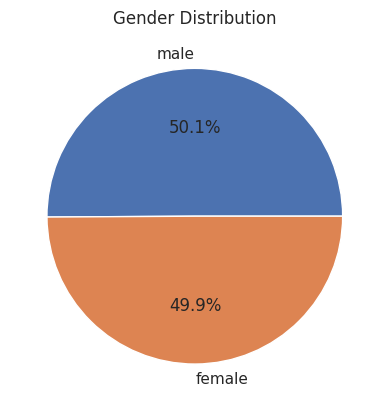

In [ ]:
# Plot distribution of Gender label
plt.pie(df['sex'].value_counts(), labels=df['sex'].unique().tolist(), autopct='%1.1f%%')
plt.title('Gender Distribution')
#plt.savefig("gender.jpg");

In [ ]:
df.columns

Index(['region', 'churn', 'type_of_plan', 'highest_level_education',
       'work_status', 'sex', 'relationship_status', 'weeks_since_claim',
       'open_policies', 'Renew_Offer_Type', 'reachability', 'type_of_vehicle',
       'age', 'Insurance Premium', 'annual_income', 'monthly_income'],
      dtype='object')

In [ ]:
categorical_cols = ['region','churn','type_of_plan','highest_level_education','work_status','sex','relationship_status','reachability','type_of_vehicle', 'open_policies', 'Renew_Offer_Type']

In [ ]:
continous_numerical_cols = ['Insurance Premium','weeks_since_claim','age','monthly_income','annual_income']

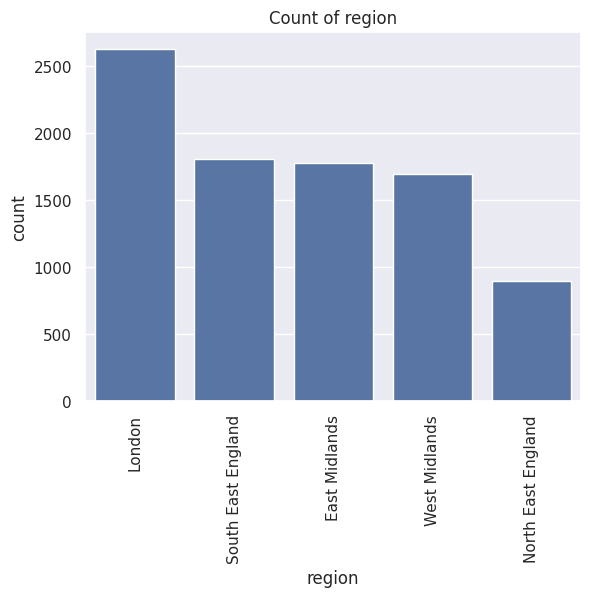

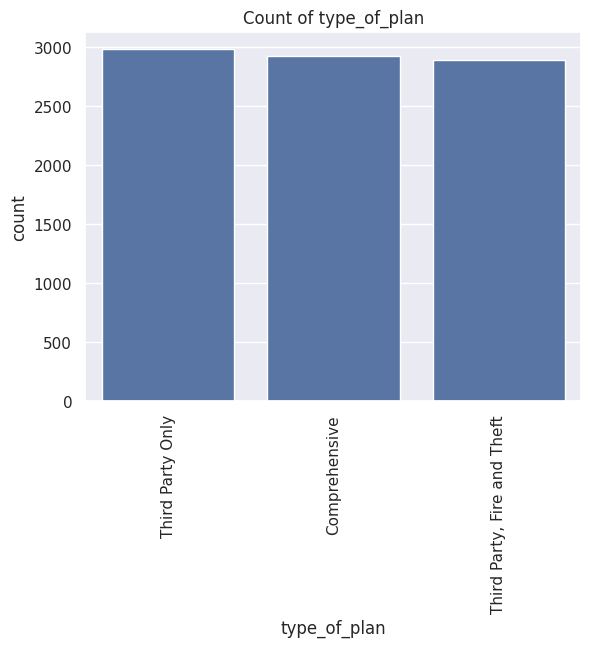

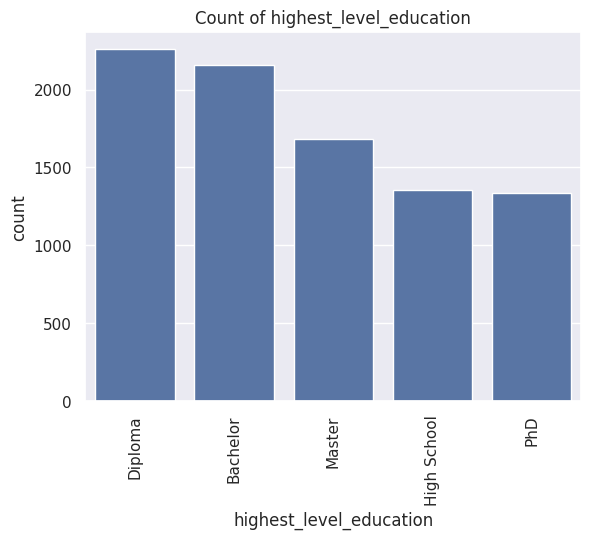

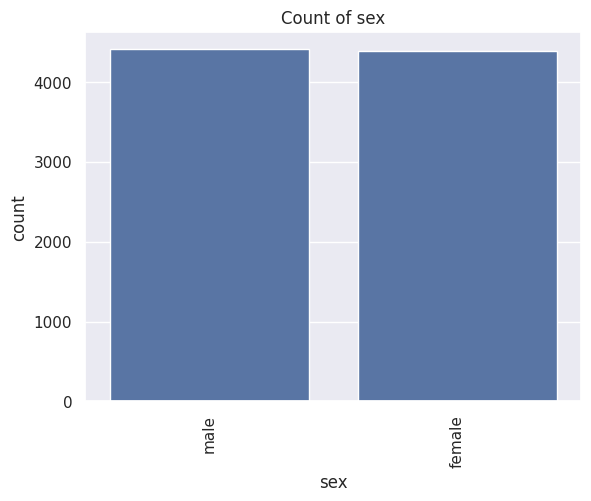

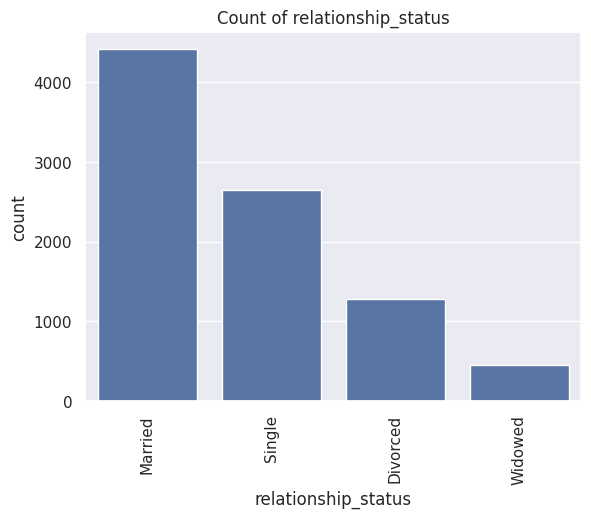

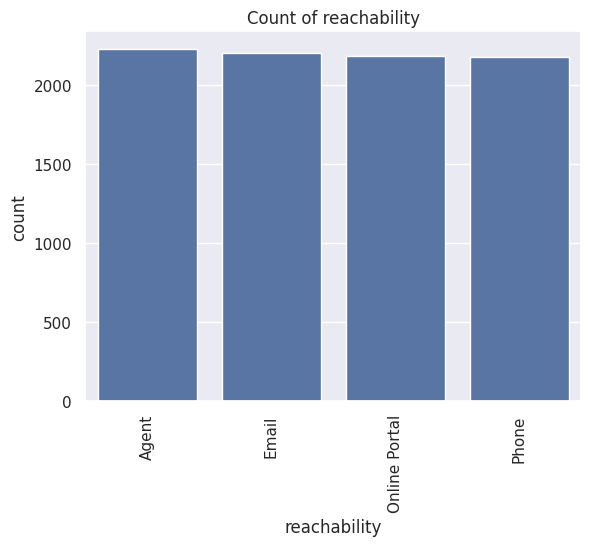

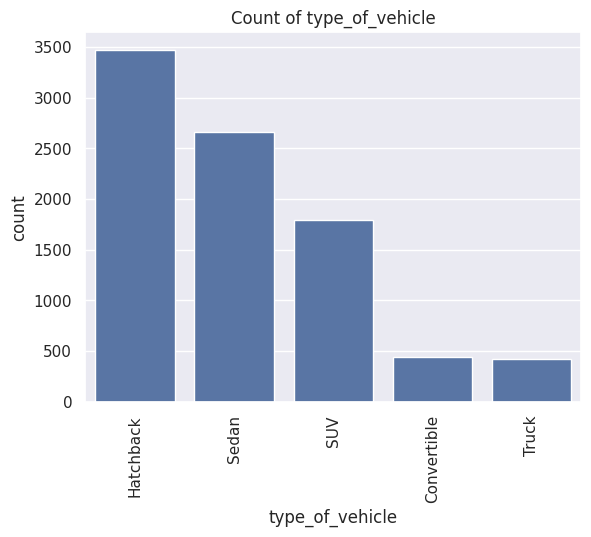

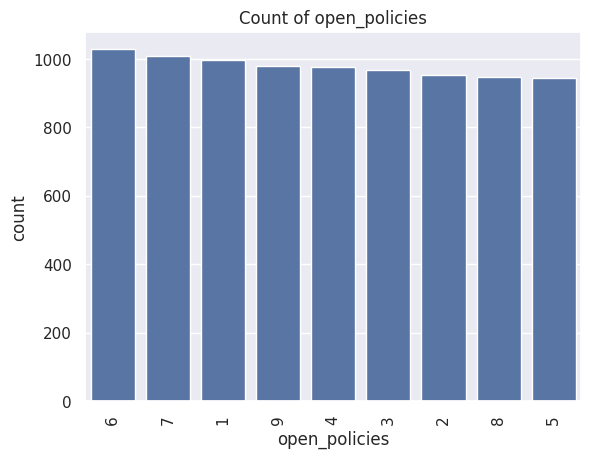

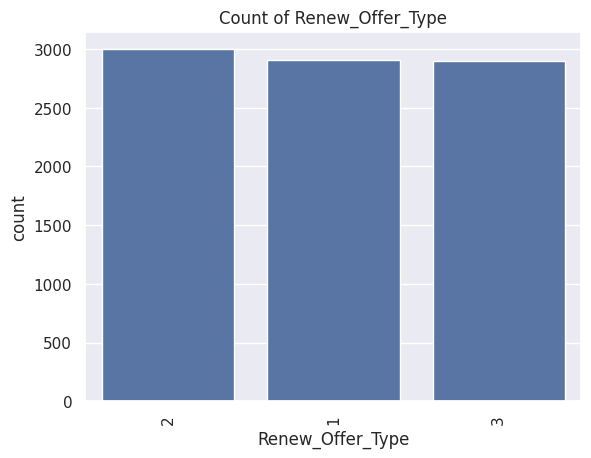

In [ ]:
for cat_column  in categorical_cols:

  def plot(cat_column):

      # Plot the counts each variable in a category
      sns.countplot(x=cat_column, data=df,order = df[cat_column].value_counts().sort_values(ascending=False).index)

      plt.title('Count of '+ cat_column)
      plt.xticks(rotation=90)
      plt.show()

  plot(cat_column)

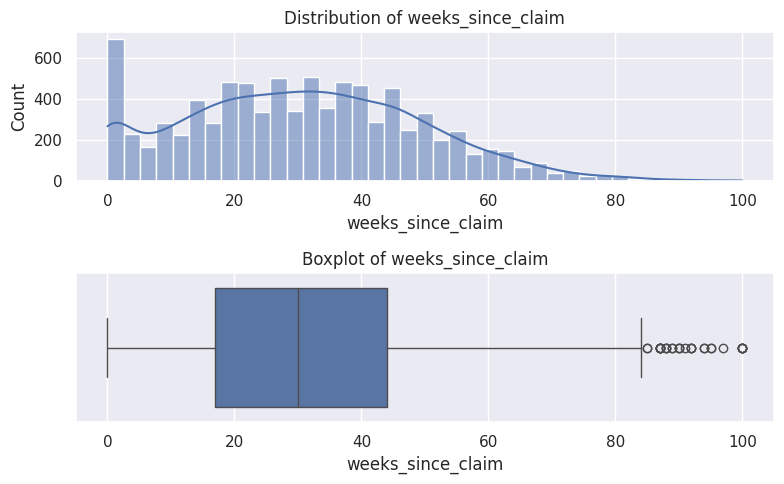

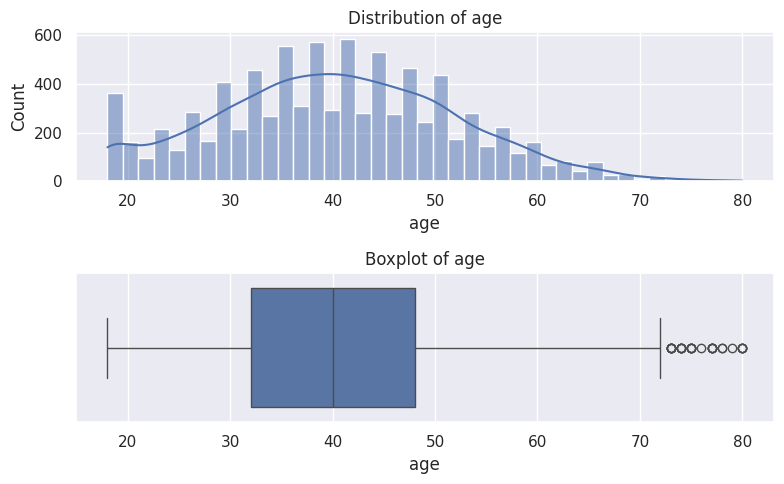

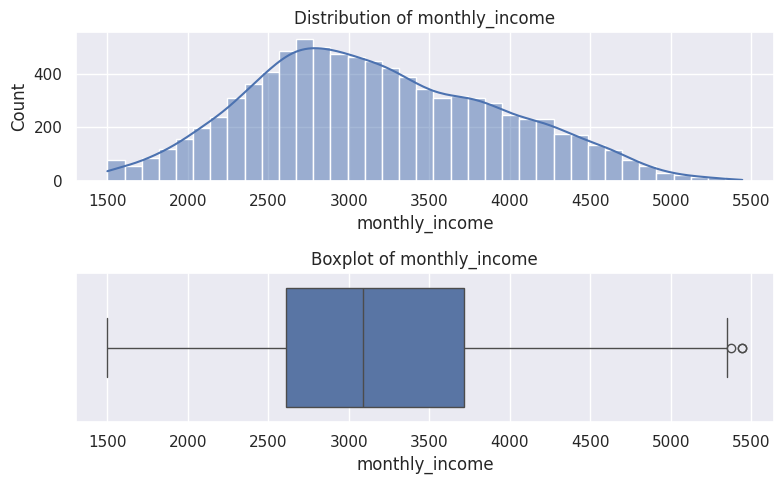

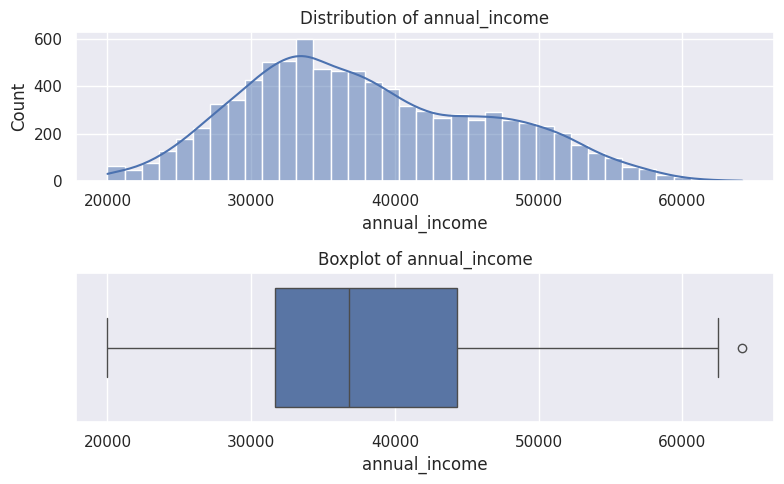

In [ ]:
for num_column in continous_numerical_cols:

  def plot(num_column):
      fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

      # Plot the distribution with the bell curve line
      sns.histplot(df[num_column], kde=True ,ax=ax1)
      ax1.set_title('Distribution of '+ num_column)

      # Plot the boxplot
      sns.boxplot(df[num_column], orient='h', ax=ax2)
      ax2.set_title('Boxplot of '+ num_column)

      plt.tight_layout()
      plt.show()

  plot(num_column)

## **Bivariate Analysis**

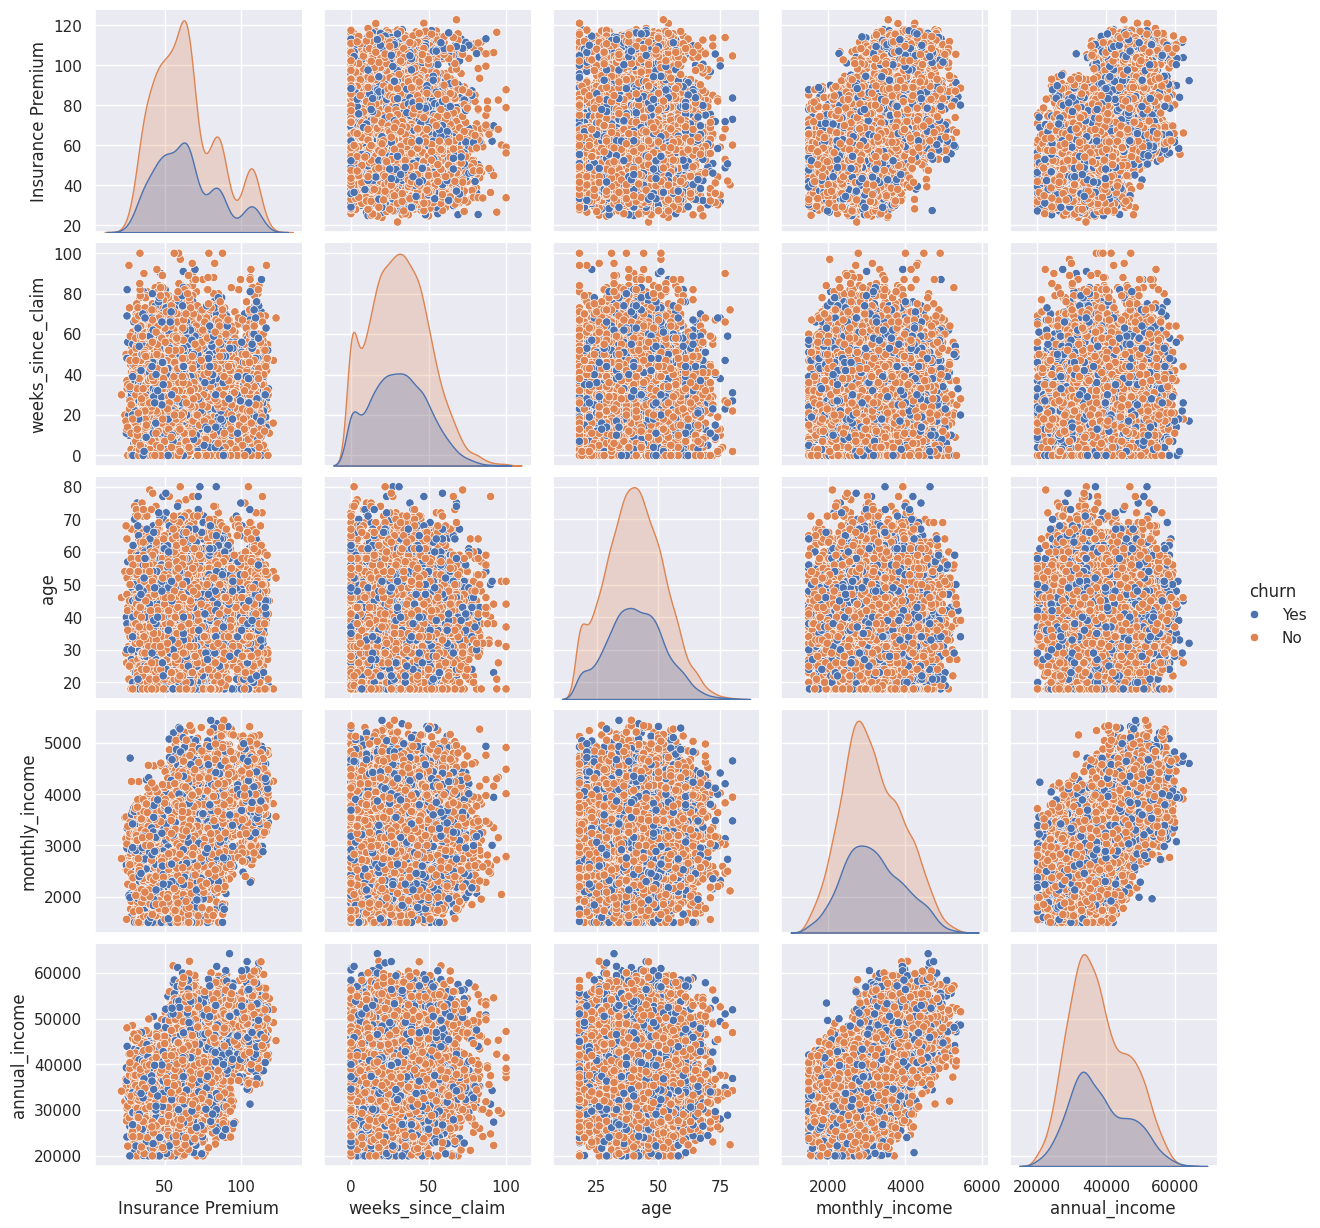

In [ ]:
sns.pairplot(data=df, hue='churn', vars=continous_numerical_cols)
plt.show()

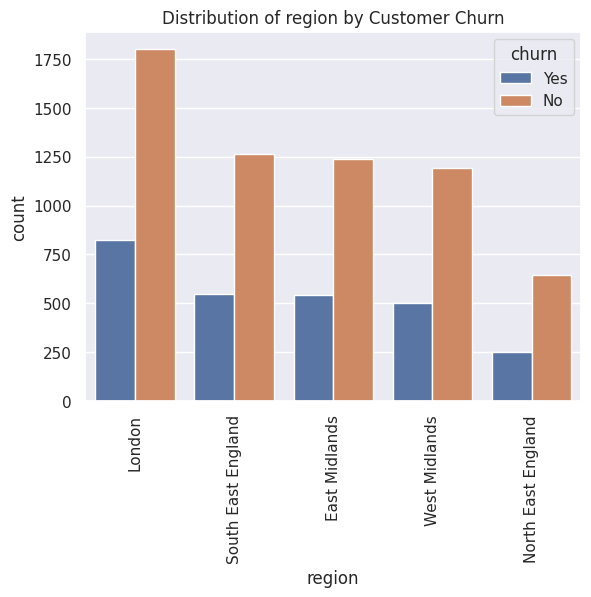

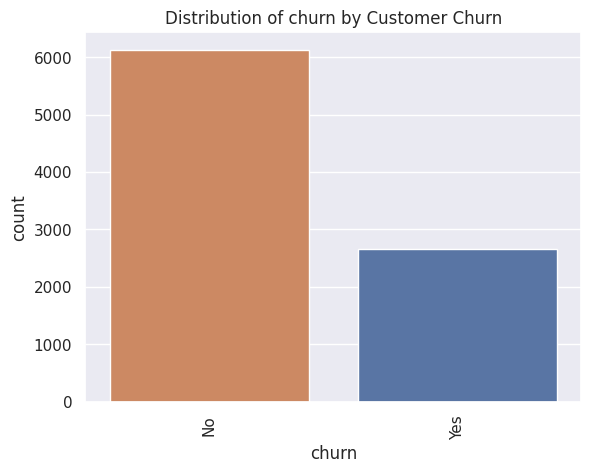

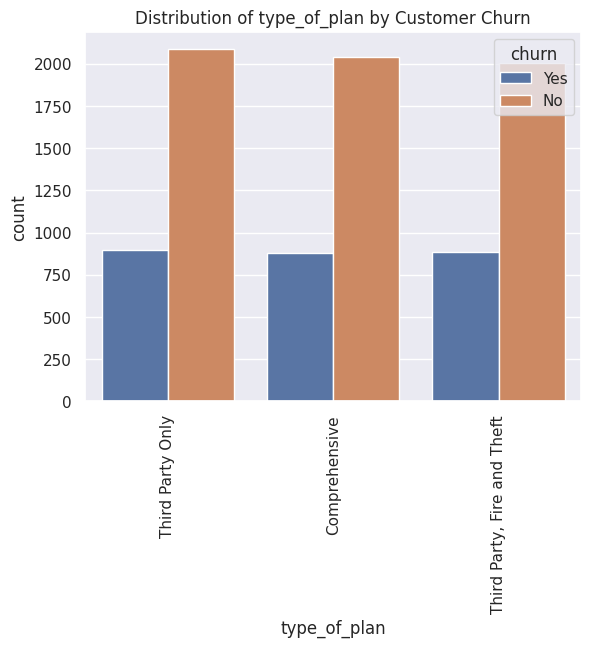

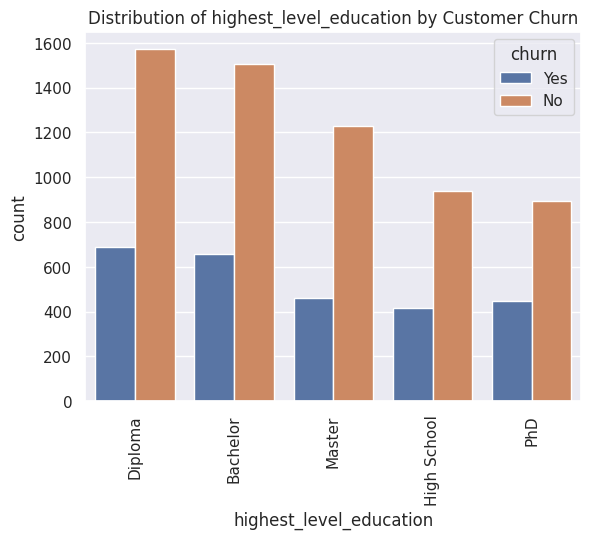

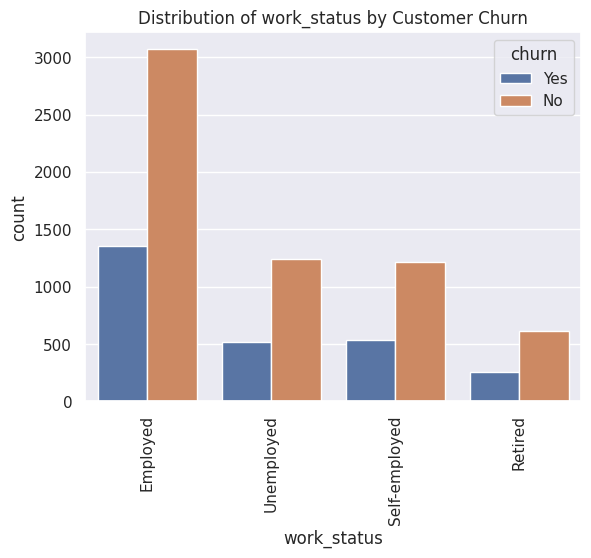

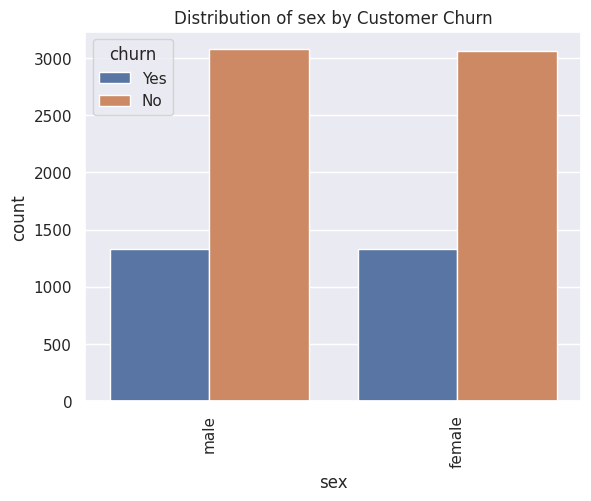

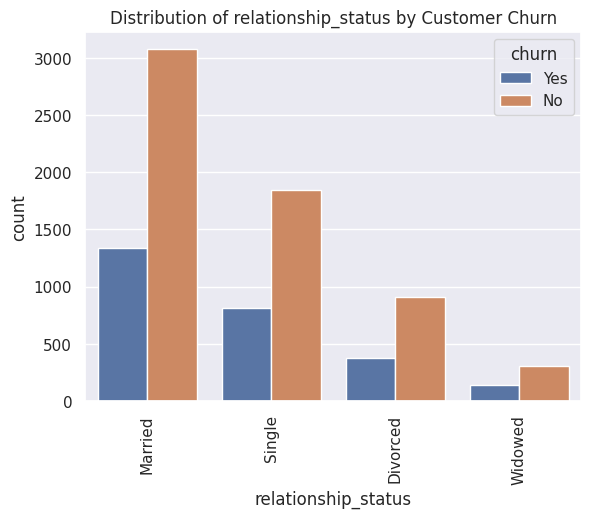

In [ ]:
for cat_column  in categorical_cols:

  def plot(cat_column):

      # Plot the counts each variable in a category
      sns.countplot(x=cat_column, hue='churn', data=df,order = df[cat_column].value_counts().sort_values(ascending=False).index)

      plt.title('Distribution of '+ cat_column + ' by Customer Churn')
      plt.xticks(rotation=90)
      plt.show()

  plot(cat_column)

In [ ]:
sns.countplot(x='work_status', hue= 'type_of_plan' , data=df,order = df['work_status'].value_counts().sort_values(ascending=False).index)

plt.title('Distribution of Insurance Type by work status of customers')
plt.show()

In [ ]:
sns.countplot(x='highest_level_education', hue= 'type_of_plan' , data=df,order = df['highest_level_education'].value_counts().sort_values(ascending=False).index)

plt.title('Distribution of Insurance Type by highest education level of customers')
plt.show()

## **Cross-tabulation and Chi-Square Test**

Chi-Square Test for churn and region:
Chi2: 4.435327053962419, p-value: 0.3502850443415832



Chi-Square Test for churn and type_of_plan:
Chi2: 0.3308530011478842, p-value: 0.847532154042612



Chi-Square Test for churn and highest_level_education:
Chi2: 13.167743205291597, p-value: 0.010484599970920128



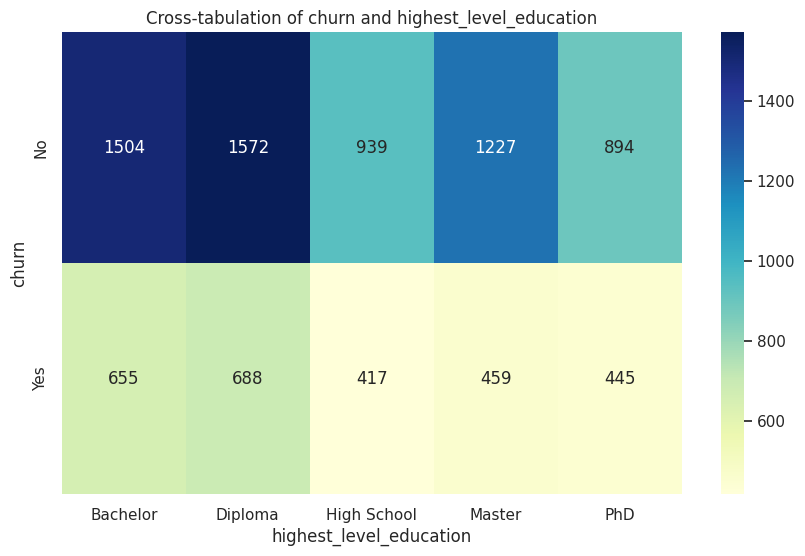

Chi-Square Test for churn and work_status:
Chi2: 0.8441936964773926, p-value: 0.838869858879426



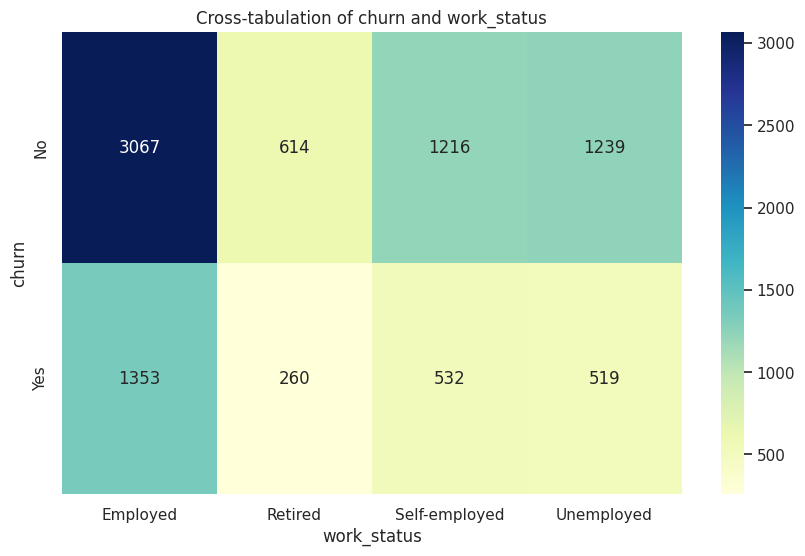

Chi-Square Test for churn and sex:
Chi2: 0.0018298482179105197, p-value: 0.9658795176110305



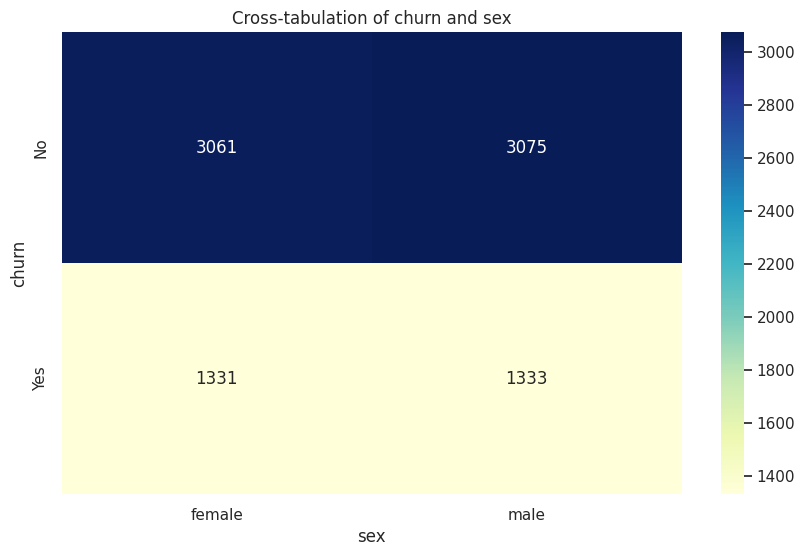

Chi-Square Test for churn and relationship_status:
Chi2: 1.3604443503577561, p-value: 0.7148324146493501



Chi-Square Test for churn and reachability:
Chi2: 1.0503296764889258, p-value: 0.7890761560681412



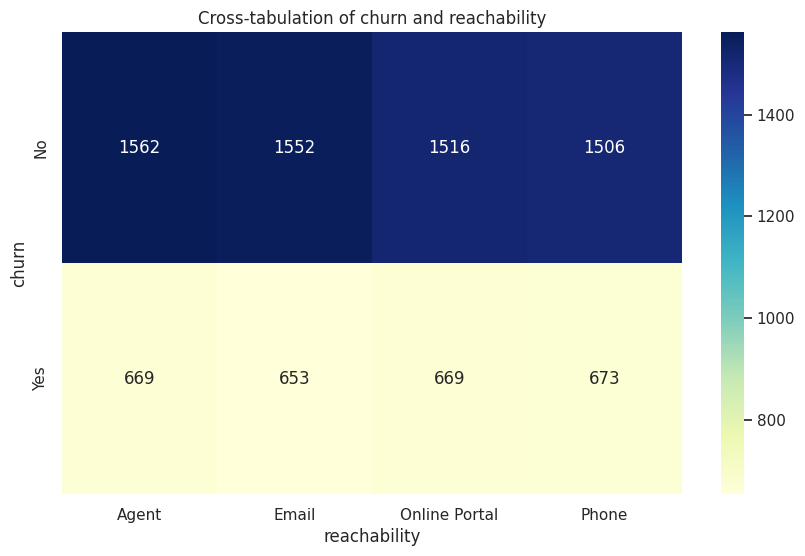

Chi-Square Test for churn and type_of_vehicle:
Chi2: 0.318272710056864, p-value: 0.9886042800324651



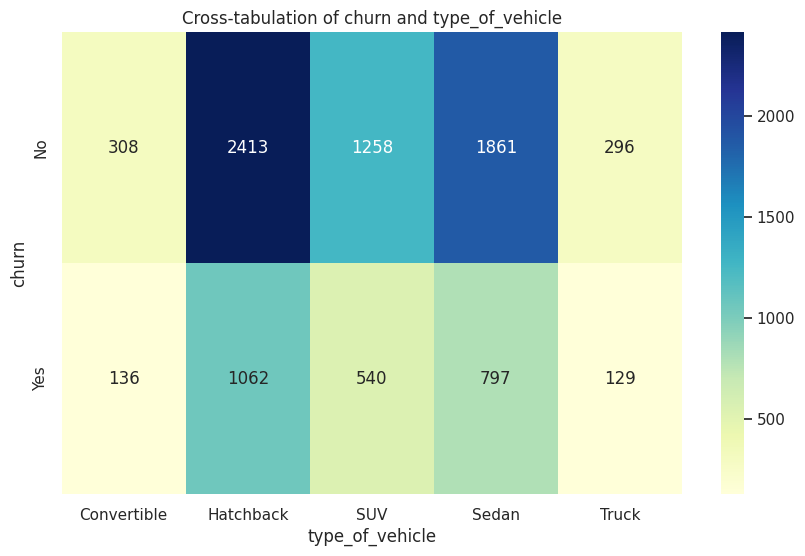

Chi-Square Test for churn and open_policies:
Chi2: 6.509070356984241, p-value: 0.5904017319625483



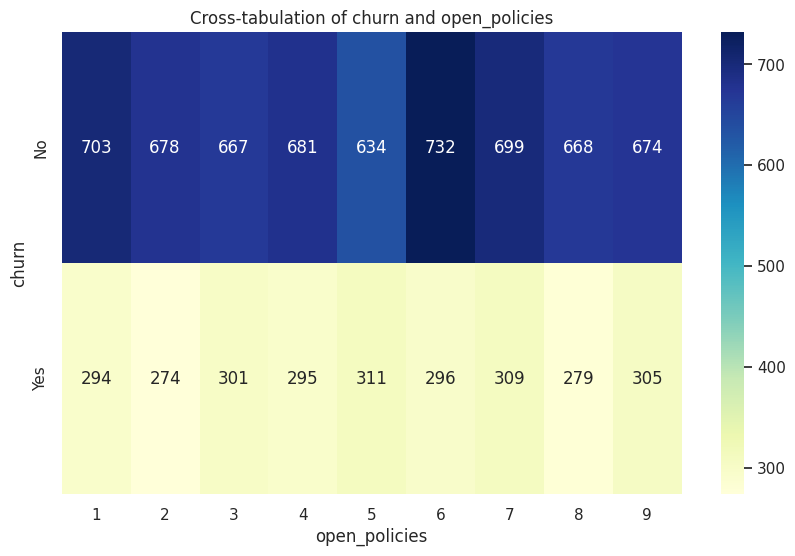

Chi-Square Test for churn and Renew_Offer_Type:
Chi2: 0.047672427265086886, p-value: 0.9764456251435328



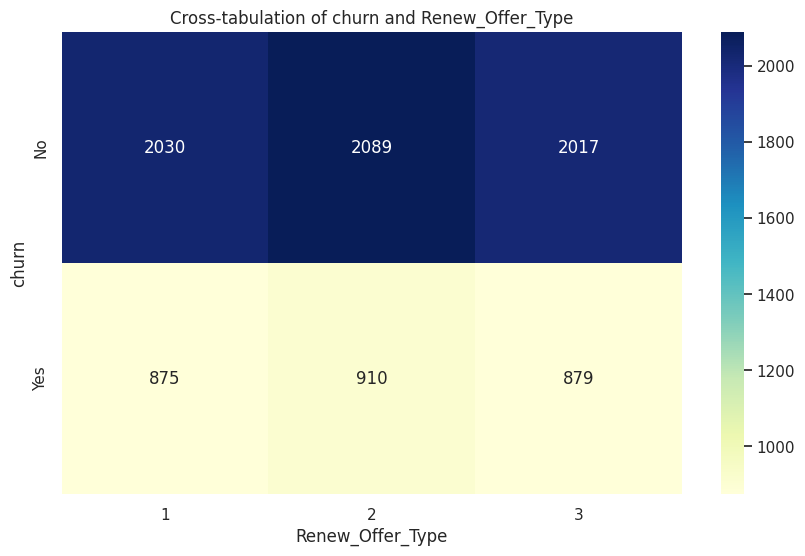

In [ ]:
from scipy.stats import chi2_contingency
# Convert categorical variables to categorical type
categorical_cols = ['region','type_of_plan','highest_level_education','work_status','sex','relationship_status','reachability','type_of_vehicle', 'open_policies', 'Renew_Offer_Type']
df1 = df
df1[categorical_cols] = df1[categorical_cols].astype('category')

# Cross-tabulation and Chi-Square Test
for col in categorical_cols:
    crosstab = pd.crosstab(df1['churn'], df[col])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f'Chi-Square Test for churn and {col}:')
    print(f'Chi2: {chi2}, p-value: {p}\n')

    # Plotting the crosstab result
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Cross-tabulation of churn and {col}')
    plt.xlabel(col)
    plt.ylabel('churn')
    plt.show()

## **Correlation Plot**

In [ ]:
#correlation plot to check if numerical columns are correlated which each other
plt.figure(figsize =(10,10))
cors = df[continous_numerical_cols].corr()
sns.heatmap(cors,annot=True,cmap='YlGnBu')
plt.title('correlation plot')

Text(0.5, 1.0, 'correlation plot')

# **Data Preprocessing**

In [ ]:
for var in continous_numerical_cols:
    def drop_outliers(var):
        q1,q3 = np.percentile(df[var],[25,75])
        iqr = q3 - q1
        lower = q1 - 1.5* iqr
        upper = q3 + 1.5* iqr
        df = df[df[var] < upper]
        df = df[df[var]> lower]
        df.reset_index(drop=True, inplace= True)
        return df


## **Feature Engineering**

In [ ]:

# Convert categorical variables to categorical type
categorical_cols = ['region', 'type_of_plan', 'highest_level_education', 'work_status', 'sex', 'relationship_status', 'reachability', 'type_of_vehicle']
df[categorical_cols] = df[categorical_cols].astype('category')

# Binning age into categories
age_bins = [18, 30, 40, 50, 60, 80]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-80']
df['age_binned'] = pd.cut(df['age'], bins=age_bins,
                          labels=age_labels, right=False)

# Binning annual income into categories
income_bins = [0, 20000, 40000, 60000, 80000, 100000]
income_labels = ['0-19k', '20k-39k', '40k-59k', '60k-79k', '80k-100k']
df['annual_income_binned'] = pd.cut(df['annual_income'], bins=income_bins,
                                    labels=income_labels, right=False)

# Creating domain-specific feature: ratio of insurance premium to income
df['premium_to_income_ratio'] = df['Insurance Premium'] / df['annual_income']

# Display the first few rows of the dataframe to verify the changes
print(df.head())


               region churn                 type_of_plan  \
0  South East England   Yes                Comprehensive   
1              London    No  Third Party, Fire and Theft   
2  South East England    No                Comprehensive   
3       East Midlands    No                Comprehensive   
4       East Midlands    No                Comprehensive   

  highest_level_education work_status   sex relationship_status  \
0                Bachelor    Employed  male              Single   
1                Bachelor  Unemployed  male             Married   
2                     PhD    Employed  male              Single   
3                  Master    Employed  male              Single   
4             High School     Retired  male             Married   

   weeks_since_claim open_policies Renew_Offer_Type   reachability  \
0                 45             3                3  Online Portal   
1                 44             9                2  Online Portal   
2                  0      

In [ ]:
df1 = df

In [ ]:
df = df.drop(['age','annual_income','Insurance Premium'],axis=1)

## **Encoding**

In [ ]:
 #Seperating the dataset into Features (X) and Target (y)
X = df.drop('churn',axis=1)
y = df['churn']

In [ ]:
cat1 = []
for i in X.columns:
    if X[i].dtype == 'O':
        cat1.append(i)
    elif X[i].dtype == 'category':
        cat1.append(i)

In [ ]:
encoder =  OneHotEncoder(drop='first',dtype=int)
enc_data =pd.DataFrame(encoder.fit_transform(X[cat1]).toarray())
#enc_data.columns = encoder.get_feature_names_out()
enc_data.columns = encoder.get_feature_names_out(cat1)
X = X.join(enc_data)

X.drop(cat1,axis=1,inplace=True)

In [ ]:
X.columns

Index(['weeks_since_claim', 'monthly_income', 'premium_to_income_ratio',
       'region_London', 'region_North East England',
       'region_South East England', 'region_West Midlands',
       'type_of_plan_Third Party Only',
       'type_of_plan_Third Party, Fire and Theft',
       'highest_level_education_Diploma',
       'highest_level_education_High School', 'highest_level_education_Master',
       'highest_level_education_PhD', 'work_status_Retired',
       'work_status_Self-employed', 'work_status_Unemployed', 'sex_male',
       'relationship_status_Married', 'relationship_status_Single',
       'relationship_status_Widowed', 'open_policies_2', 'open_policies_3',
       'open_policies_4', 'open_policies_5', 'open_policies_6',
       'open_policies_7', 'open_policies_8', 'open_policies_9',
       'Renew_Offer_Type_2', 'Renew_Offer_Type_3', 'reachability_Email',
       'reachability_Online Portal', 'reachability_Phone',
       'type_of_vehicle_Hatchback', 'type_of_vehicle_SUV',
   

In [ ]:
# Create a dictionary to map values to integers
value_map = {'No': 0, 'Yes': 1}

# Map the values in y to integers
y = y.map(value_map)


## **Scaling**

In [ ]:
col1 = X.columns

In [ ]:
#scaling all columns using minmax scaler
scaler =  MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=col1)

In [ ]:
X.head()

weeks_since_claim  monthly_income  premium_to_income_ratio  region_London  \
0               0.45        0.464276                 0.255540            0.0   
1               0.44        0.684020                 0.363519            1.0   
2               0.00        0.490202                 0.344200            0.0   
3               0.61        0.354189                 0.389986            0.0   
4               0.22        0.263951                 0.586559            0.0   

   region_North East England  region_South East England  region_West Midlands  \
0                        0.0                        1.0                   0.0   
1                        0.0                        0.0                   0.0   
2                        0.0                        1.0                   0.0   
3                        0.0                        0.0                   0.0   
4                        0.0                        0.0                   0.0   

   type_of_plan_Third Party Only  type_of_plan_Third Party, Fire and Theft  \
0                            0.0                                       0.0   
1                            0.0                                       1.0   
2                            0.0                                       0.0   
3                            0.0                                       0.0   
4                            0.0                                       0.0   

   highest_level_education_Diploma  highest_level_education_High School  \
0                              0.0                                  0.0   
1                              0.0                                  0.0   
2                              0.0                                  0.0   
3                              0.0                                  0.0   
4                              0.0                                  1.0   

   highest_level_education_Master  highest_level_education_PhD  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          1.0   
3                             1.0                          0.0   
4                             0.0                          0.0   

   work_status_Retired  work_status_Self-employed  work_status_Unemployed  \
0                  0.0                        0.0                     0.0   
1                  0.0                        0.0                     1.0   
2                  0.0                        0.0                     0.0   
3                  0.0                        0.0                     0.0   
4                  1.0                        0.0                     0.0   

   sex_male  relationship_status_Married  relationship_status_Single  \
0       1.0                          0.0                         1.0   
1       1.0                          1.0                         0.0   
2       1.0                          0.0                         1.0   
3       1.0                          0.0                         1.0   
4       1.0                          1.0                         0.0   

   relationship_status_Widowed  open_policies_2  open_policies_3  \
0                          0.0              0.0              1.0   
1                          0.0              0.0              0.0   
2                          0.0              0.0              0.0   
3                          0.0              0.0              0.0   
4                          0.0              0.0              0.0   

   open_policies_4  open_policies_5  open_policies_6  open_policies_7  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              1.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0             

## **Data OverSampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# oversampling the dataset to balance the target (y) classes
ros = RandomOverSampler(random_state=42)
X,y  = ros.fit_resample(X,y)


## **Data Splitting**

In [ ]:
# spliting the dataset into training and test
#for the features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.30,
                                                    random_state=0)

# **Model Development**

In [ ]:
def model_to_use(input_ml_algo):
    if input_ml_algo == 'DT':
        model = DecisionTreeClassifier()
    elif input_ml_algo == 'RF':
        model = RandomForestClassifier()
    elif input_ml_algo == 'XGBC':
        model = XGBClassifier()
    elif input_ml_algo=='LR':
        model=LogisticRegression()
    elif input_ml_algo=='KNN':
        model=KNeighborsClassifier()
    elif input_ml_algo=='CBC':
        model = CatBoostClassifier(verbose=0)
    return model

In [ ]:
model1 = model_to_use('LR')
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression Accuracy: 0.5081477457903314


In [ ]:
model2 = model_to_use('DT')
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Decision Tree Classifier Accuracy:", accuracy)

Decision Tree Classifier Accuracy: 0.7419880499728408


In [ ]:
model3 = model_to_use('RF')
model3.fit(X_train,y_train)
y_pred3 = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred3)
print("Random Forest classifier Accuracy:", accuracy)

Random Forest classifier Accuracy: 0.8457360130363932


In [ ]:
model4 = model_to_use('XGBC')
model4.fit(X_train,y_train)
y_pred4 = model4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred4)
print("XGBOOST classifier Accuracy:", accuracy)

XGBOOST classifier Accuracy: 0.7172732210755024


In [ ]:
model5 = model_to_use('KNN')
model5.fit(X_train,y_train)
y_pred5 = model5.predict(X_test)
accuracy = accuracy_score(y_test, y_pred5)
print("K Nearest Neighbour classifier Accuracy:", accuracy)

K Nearest Neighbour classifier Accuracy: 0.5915263443780554


In [ ]:
model6 = model_to_use('CBC')
model6.fit(X_train,y_train)
y_pred6 = model6.predict(X_test)
accuracy = accuracy_score(y_test, y_pred6)
print("K Nearest Neighbour classifier Accuracy:", accuracy)

K Nearest Neighbour classifier Accuracy: 0.686040195545899


# **Hyper Parameter Tuning**

In [ ]:
# Define the classifiers and their parameter grids for RandomizedSearchCV
"""classifiers = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': np.logspace(-3, 3, 10),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': randint(50, 300),
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        {'n_estimators': randint(50, 300),
        'max_depth': randint(3, 12),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.7, 0.3)
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': randint(3, 12),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    'CatBoost': (CatBoostClassifier(verbose=0), {
        'iterations': randint(50, 200),
        'learning_rate': uniform(0.01, 0.1),
        'depth': randint(6, 11)
    })
}

# Perform RandomizedSearchCV with cross-validation for each classifier
best_estimators = {}

for name, (clf, param_grid) in classifiers.items():
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
     n_iter=50, cv=5, n_jobs=-1, verbose=1, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimators[name] = random_search.best_estimator_
    print(f'Best parameters for {name}: {random_search.best_params_}')
    print(f'Best score for {name}: {random_search.best_score_}\n')

# Evaluate the best estimators on the test set
for name, best_estimator in best_estimators.items():
    test_score = best_estimator.score(X_test, y_test)
    print(f'Test score for {name}: {test_score}')"""

"classifiers = {\n    'Logistic Regression': (LogisticRegression(max_iter=1000), {\n        'C': np.logspace(-3, 3, 10),\n        'penalty': ['l1', 'l2'],\n        'solver': ['liblinear', 'saga']\n    }),\n    'Decision Tree': (DecisionTreeClassifier(), {\n        'criterion': ['gini', 'entropy'],\n        'max_depth': [None, 10, 20, 30],\n        'min_samples_split': randint(2, 11),\n        'min_samples_leaf': randint(1, 5)\n    }),\n    'Random Forest': (RandomForestClassifier(), {\n        'n_estimators': randint(50, 300),\n        'criterion': ['gini', 'entropy'],\n        'max_depth': [None, 10, 20, 30],\n        'min_samples_split': randint(2, 11),\n        'min_samples_leaf': randint(1, 5)\n    }),\n    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),\n        {'n_estimators': randint(50, 300),\n        'max_depth': randint(3, 12),\n        'learning_rate': uniform(0.01, 0.3),\n        'subsample': uniform(0.7, 0.3)\n    }),\n    'KNN': (KNeighborsCla

Fitting 5 folds for each of 40 candidates, totalling 200 fits
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Best score for Logistic Regression: 0.5132712456344586

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score for Decision Tree: 0.6885913853317811

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
Best score for Random Forest: 0.7769499417927823

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost: {'learning_rate': 0.16322419077326972, 'max_depth': 11, 'n_estimators': 111, 'subsample': 0.766632343141219}
Best score for XGBoost: 0.7374854481955764

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Best score for KNN: 0.6818393480791618

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for CatBoost: {'depth': 10, 'iterations': 180, 'learning_rate': 0.08607850486168975}
Best score for CatBoost: 0.730384167636787

Test score for Logistic Regression: 0.5149375339489408

Test score for Decision Tree: 0.7392721347093971

Test score for Random Forest: 0.8487235198261814

Test score for XGBoost: 0.7764801738185768

Test score for KNN: 0.720532319391635

Test score for CatBoost: 0.7927756653992395

# **Model Evaluation**

In [ ]:
def performance(model,X_train,y_train,X_test, y_test):
    y_pred = model.predict(X_test)

    # Predict probability for test dataset
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = [x[1] for x in y_pred_prob]

    disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['No','Yes'])

    print("\n Accuracy Score : \n ",accuracy_score(y_test,y_pred))
    print("\n AUC Score : \n", roc_auc_score(y_test, y_pred_prob))
    print("\n Confusion Matrix : \n ",confusion_matrix(y_test, y_pred))
    print("\n Classification Report : \n",classification_report(y_test, y_pred))

    print("\n ROC curve : \n")
    sns.set_style("white")
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()

## **Logistic Regression**

In [ ]:
LR_model=LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.1)
LR_model.fit(X_train,y_train)
performance(LR_model,X_train,y_train,X_test, y_test)


 Accuracy Score : 
  0.5149375339489408

 AUC Score : 
 0.5278047090288606

 Confusion Matrix : 
  [[ 775 1098]
 [ 688 1121]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.53      0.41      0.46      1873
           1       0.51      0.62      0.56      1809

    accuracy                           0.51      3682
   macro avg       0.52      0.52      0.51      3682
weighted avg       0.52      0.51      0.51      3682


 ROC curve : 



## **Decision Tree Classifier**

In [ ]:
DT_model=DecisionTreeClassifier(criterion = 'gini', max_depth = 30,
                                min_samples_leaf = 1, min_samples_split = 2,
                                random_state= 40)
DT_model.fit(X_train,y_train)
performance(DT_model,X_train,y_train,X_test, y_test)


 Accuracy Score : 
  0.7392721347093971

 AUC Score : 
 0.7413183238461545

 Confusion Matrix : 
  [[1168  705]
 [ 255 1554]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.62      0.71      1873
           1       0.69      0.86      0.76      1809

    accuracy                           0.74      3682
   macro avg       0.75      0.74      0.74      3682
weighted avg       0.76      0.74      0.74      3682


 ROC curve : 



## **Random Forest classifier**


 Accuracy Score : 
  0.8487235198261814

 AUC Score : 
 0.8940627880352641

 Confusion Matrix : 
  [[1673  200]
 [ 357 1452]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      1873
           1       0.88      0.80      0.84      1809

    accuracy                           0.85      3682
   macro avg       0.85      0.85      0.85      3682
weighted avg       0.85      0.85      0.85      3682


 ROC curve : 



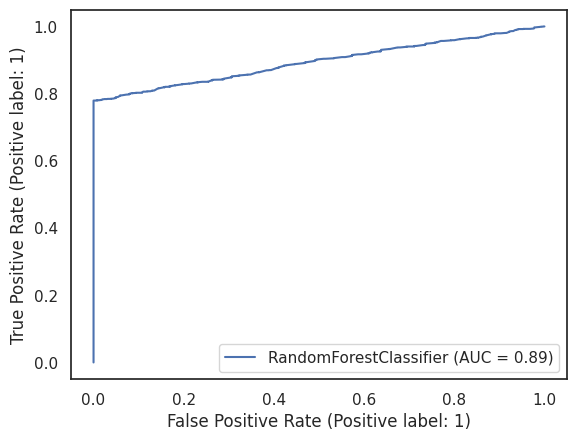

In [ ]:
RF_model=RandomForestClassifier(random_state=40, criterion = 'entropy',
                                max_depth = 30, min_samples_leaf = 1,
                                min_samples_split = 2,
                                n_estimators = 253)
RF_model.fit(X_train,y_train)
performance(RF_model,X_train,y_train,X_test, y_test)

## **XGBoost classifier**


 Accuracy Score : 
  0.7764801738185768

 AUC Score : 
 0.8760663668665041

 Confusion Matrix : 
  [[1363  510]
 [ 313 1496]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      1873
           1       0.75      0.83      0.78      1809

    accuracy                           0.78      3682
   macro avg       0.78      0.78      0.78      3682
weighted avg       0.78      0.78      0.78      3682


 ROC curve : 



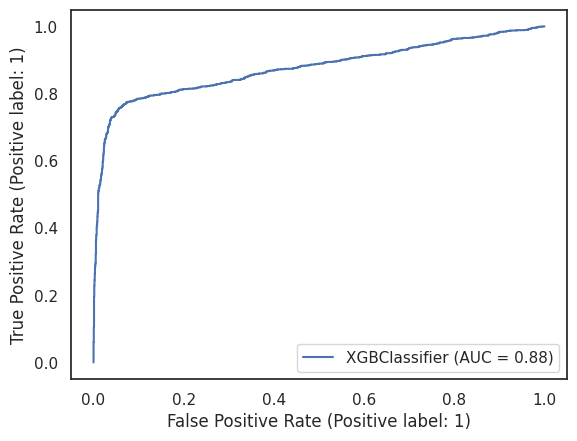

In [ ]:
XGB_model=XGBClassifier(random_state = 40, learning_rate = 0.16322419077326972,
                        max_depth = 11, n_estimators = 111,
                        subsample = 0.766632343141219)
XGB_model.fit(X_train,y_train)
performance(XGB_model,X_train,y_train,X_test, y_test)

## **K Nearest Neighbour classifier**


 Accuracy Score : 
  0.720532319391635

 AUC Score : 
 0.8583414717360578

 Confusion Matrix : 
  [[1062  811]
 [ 218 1591]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.57      0.67      1873
           1       0.66      0.88      0.76      1809

    accuracy                           0.72      3682
   macro avg       0.75      0.72      0.71      3682
weighted avg       0.75      0.72      0.71      3682


 ROC curve : 



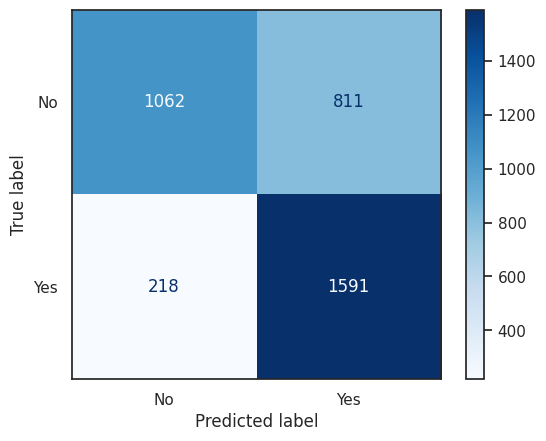

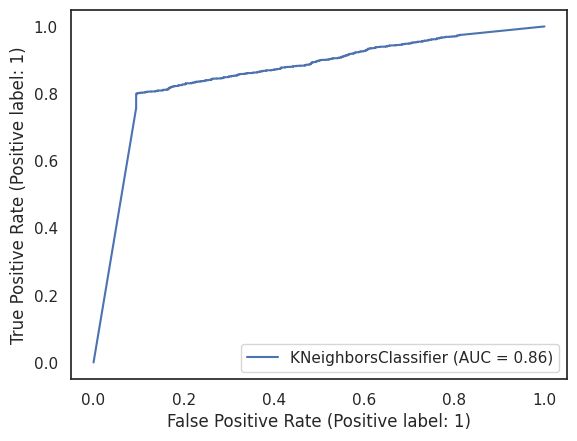

In [ ]:
KNN_model=KNeighborsClassifier( metric = 'euclidean', n_neighbors = 4,
                               weights = 'distance')
KNN_model.fit(X_train,y_train)
performance(KNN_model,X_train,y_train,X_test, y_test)

## **CatBoost Classifier**


 Accuracy Score : 
  0.7927756653992395

 AUC Score : 
 0.8704682082852628

 Confusion Matrix : 
  [[1426  447]
 [ 316 1493]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1873
           1       0.77      0.83      0.80      1809

    accuracy                           0.79      3682
   macro avg       0.79      0.79      0.79      3682
weighted avg       0.79      0.79      0.79      3682


 ROC curve : 



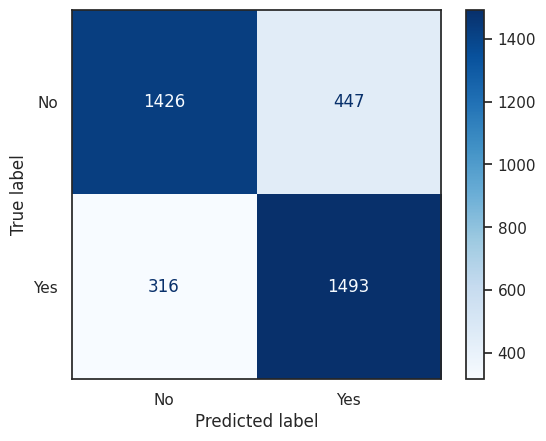

In [ ]:
CBC_model=CatBoostClassifier(verbose=0, random_state = 40,depth = 10,
                             iterations= 180,
                             learning_rate = 0.08607850486168975)
CBC_model.fit(X_train,y_train)
performance(CBC_model,X_train,y_train,X_test, y_test)

# **Model Dumping**

In [ ]:

import pickle


# Dump the model, encoder, and scaler to files
with open('/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/Model/motor_churn_model.pkl', 'wb') as model_file:
    pickle.dump(RF_model, model_file)

with open('/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/Model/encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

with open('/content/drive/MyDrive/EMMANUEL_AGBOOLA_MSc_PROJECT/Model/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model, encoder, and scaler have been dumped successfully!")

Model, encoder, and scaler have been dumped successfully!


# **Feature Importance**

Feature ranking:
1. premium_to_income_ratio (0.1349)
2. monthly_income (0.1322)
3. weeks_since_claim (0.1222)
4. sex_male (0.0257)
5. Renew_Offer_Type_2 (0.0212)
6. Renew_Offer_Type_3 (0.0209)
7. type_of_plan_Third Party, Fire and Theft (0.0203)
8. age_binned_30-39 (0.0196)
9. reachability_Email (0.0194)
10. reachability_Phone (0.0193)
11. relationship_status_Married (0.0192)
12. work_status_Self-employed (0.0188)
13. work_status_Unemployed (0.0187)
14. type_of_vehicle_Hatchback (0.0185)
15. reachability_Online Portal (0.0184)
16. age_binned_40-49 (0.0184)
17. type_of_vehicle_Sedan (0.0184)
18. highest_level_education_Diploma (0.0179)
19. type_of_plan_Third Party Only (0.0172)
20. relationship_status_Single (0.0168)
21. annual_income_binned_40k-59k (0.0166)
22. type_of_vehicle_SUV (0.0162)
23. region_West Midlands (0.0156)
24. region_South East England (0.0155)
25. age_binned_50-59 (0.0154)
26. highest_level_education_High School (0.0149)
27. open_policies_4 (0.0136)
28. open_policies_

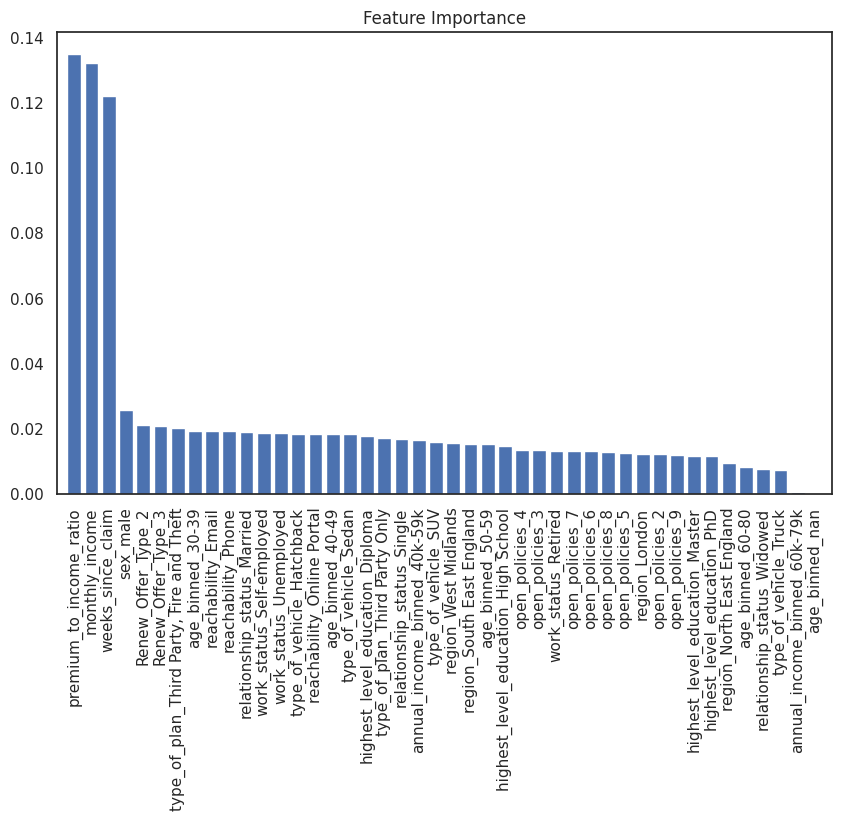

In [ ]:
# Feature importance
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Print feature importance
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {features[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# **Business Metrics**

In [ ]:
# Business metrics
churn_rate = df['churn'].value_counts(normalize=True)['Yes'] * 100
retention_rate = df['churn'].value_counts(normalize=True)['No'] * 100
arpu = df1['Insurance Premium'].mean() * 12  # Assuming ARPU is the average annual premium
avg_customer_lifespan = 5  # Assuming an average customer lifespan of 5 years
clv = arpu * avg_customer_lifespan

print(f'Churn Rate: {churn_rate:.2f}%')
print(f'Retention Rate: {retention_rate:.2f}%')
print(f'Average Revenue Per User (ARPU): £{arpu:.2f}')
print(f'Customer Lifetime Value (CLV): £{clv:.2f}')

Churn Rate: 30.27%
Retention Rate: 69.73%
Average Revenue Per User (ARPU): £768.20
Customer Lifetime Value (CLV): £3841.00
